In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import rawpy
import numpy as np
import io
from PIL import Image
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

type: RawType.Flat
pattern: [[2 3]
 [1 0]]: b'RGBG'
black: 143
white: 4079


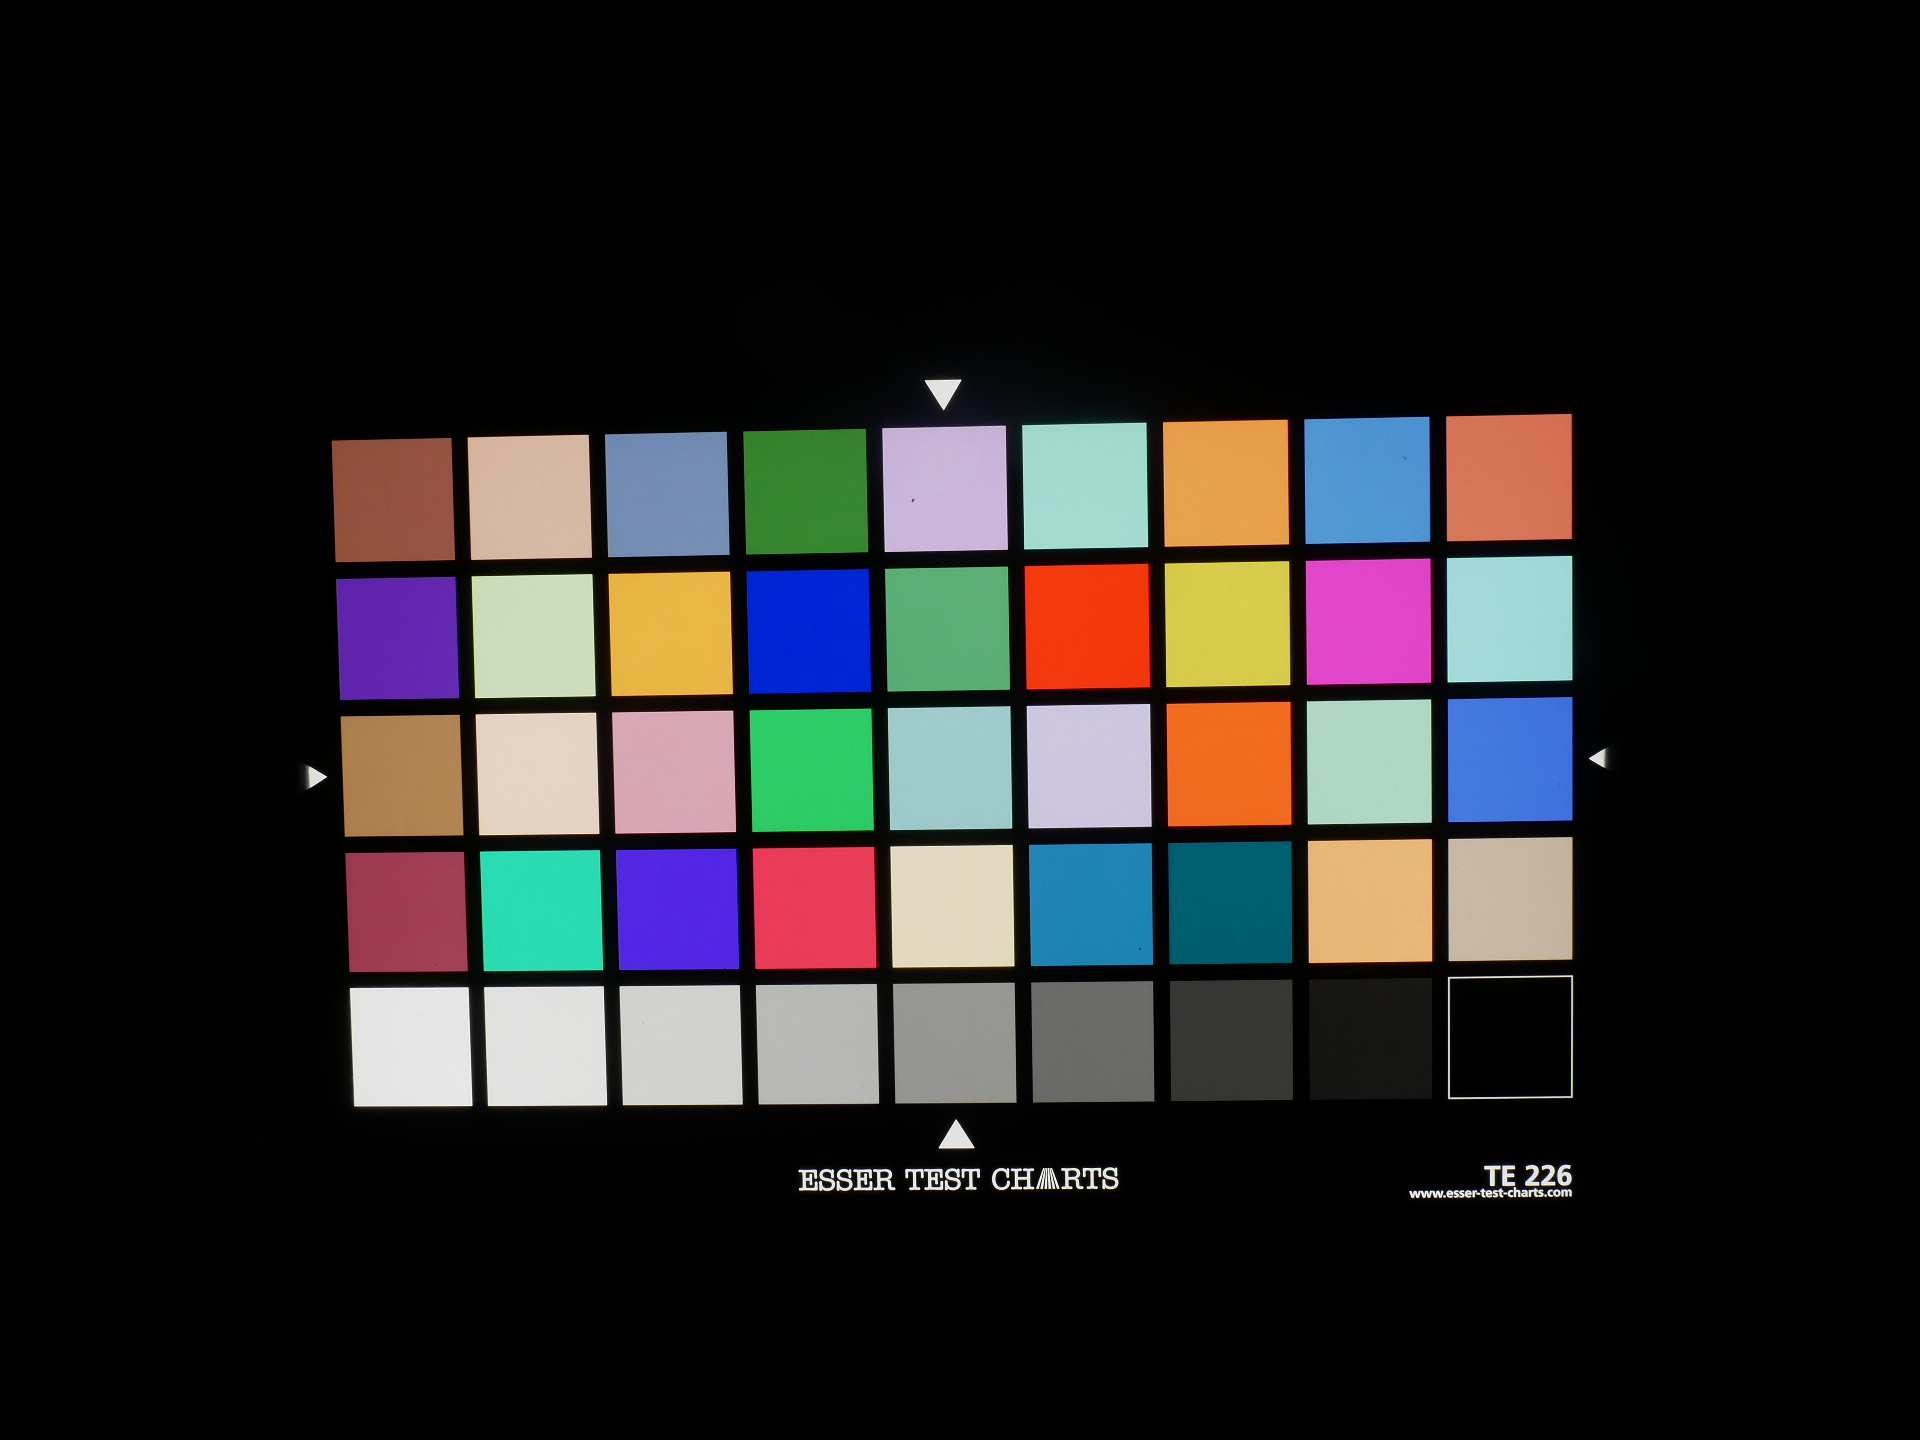

In [107]:
image_path = "data\digital\P1480487.RW2"
raw_image = ""
thumb = ""
processed = ""
raw_colors = ""
black_level = ""
white_level = ""
with rawpy.imread(image_path) as raw:
    raw_image = raw.raw_image_visible.copy()
    print(f"type: {raw.raw_type}")
    print(f"pattern: {raw.raw_pattern}: {raw.color_desc}")
    black_level = raw.black_level_per_channel[0]
    white_level = raw.camera_white_level_per_channel[0]
    print(f"black: {black_level}")
    print(f"white: {white_level}")
    thumb = raw.extract_thumb().data
    processed = raw.postprocess()
    raw_colors = raw.raw_colors
    display(Image.open(io.BytesIO(thumb)))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


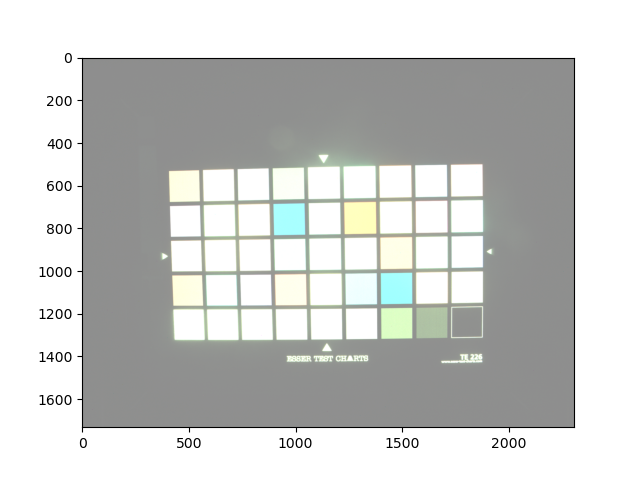

In [5]:
def demosaic(image):
    """
    Converts a raw sensor dump into a 3-tensor of RGB pixel values
    """
    # use every second line, starting at line 0, and every second pixel, starting at pixel 0
    blue = image[::2, ::2]
    # use every second line, starting at line 0, and every second pixel, starting at pixel 1
    green = image[::2, 1::2]
    # use every second line, starting at line 1, and every second pixel, starting at pixel 1
    red = image[1::2, 1::2]
    # stack into a 3-tensor
    return np.dstack((red, green, blue))

demosaiced = demosaic(raw_image)
fig1 = plt.figure()
plt.imshow(demosaiced)

In [109]:
def fix_intensity_range(image: np.ndarray, black_level: int, white_level: int):
    """
    maps an array of voltage levels from sensor in RGB pixels to correct color intensity as given by sensor black and white level
    :param image: 3D array (NxMxRGB) of voltage levels for RGB sensor 
    :param black_level: voltage readout for black, assuming identical level per pixel
    :param white_level: voltage readout for white, assuming identical level per pixel
    :return: array with adjusted range [black_level; white_level]
    """
    return np.maximum(np.minimum(image, white_level), black_level) - black_level

level_corrected = fix_intensity_range(demosaiced, black_level, white_level)
level_corrected

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 1, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 2, 0],
        [0, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 0],
        [0, 2, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 0, 1],
        ...,
        [0, 0, 2],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint16)

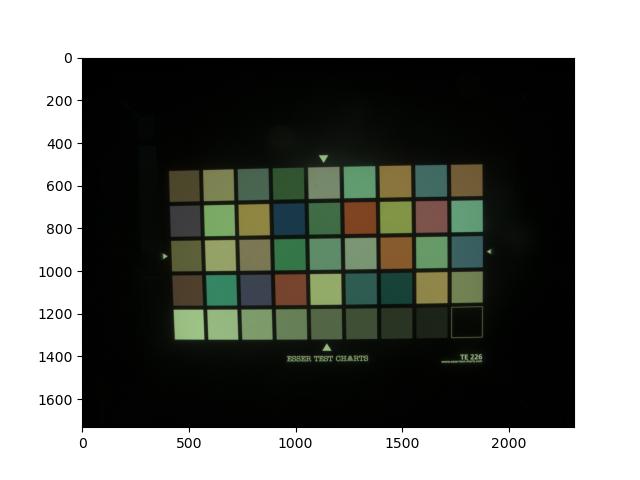

In [115]:
def invgamma(image, white_level, gamma=2.2):
    """
    convert image from int [black_level; white_level] scale to float [0, 1] scale with gamma correction
    :param image: 3D numpy array (NxMxRGB) with values between [black_level; white_level]
    :param gamma: gamma to use for gamma correction
    :return: 3D numpy array (NxMxRGB) with values between [0; 1]
    """
    image_0_to_1 = image / white_level
    lower_bounder = np.maximum(image_0_to_1, 0)
    gamma_corrected = np.power(lower_bounder, 1/gamma)
    return np.minimum(gamma_corrected, 1)

corrected = invgamma(level_corrected, white_level)
fig3 = plt.figure()
plt.imshow(corrected)

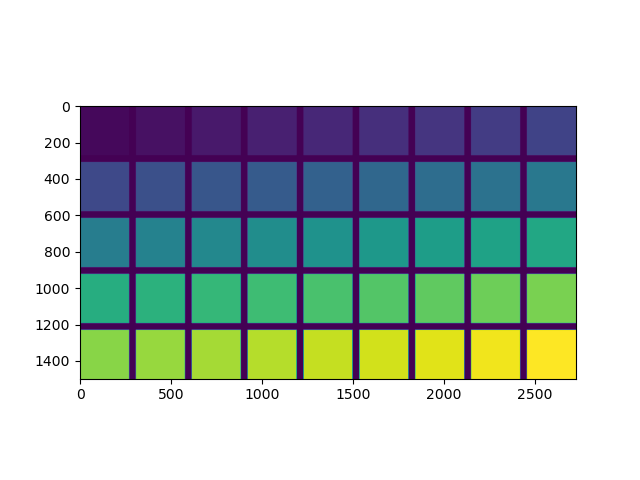

In [8]:
from functools import reduce

def color_checker_pattern_builder(num_rows, num_cols, patch_size, inter_patch_distance):
    """
    Builds a color checker pattern numpy 2D array with indexed patches
    :param num_rows: number of rows of patches
    :param num_cols: number of cols of patches
    :param patch_size: width and height of a patch in number of pixels
    :param inter_patch_distance: number pixels used as padding with value 0 between patches
    :return: a 2D numpy array where, for any (x,y) position, we find either the index of the patch,
             or 0 if there is no patch at that position
    """
    def concat_with_padding(array1, array2, axis=1):
        return np.concatenate(
            (
                np.pad(
                    array1,
                    ((0,inter_patch_distance-inter_patch_distance*axis),(0,inter_patch_distance*axis)),
                    'constant',constant_values=0
                ),
                array2
            )
            , axis=axis)
    
    color_checker = reduce(
        lambda array1, array2: concat_with_padding(array1, array2, axis=0),
        [
            reduce(
                concat_with_padding,
                [np.full((patch_size, patch_size), (x * num_cols) + (y + 1), dtype=np.uint8) for y in range(num_cols)]
            )
            for x in range(num_rows)
        ]
    )
    return color_checker

plt.close('all')
color_checker = color_checker_pattern_builder(5, 9, 270, 37)
fig_checker = plt.figure()
plt.imshow(color_checker)

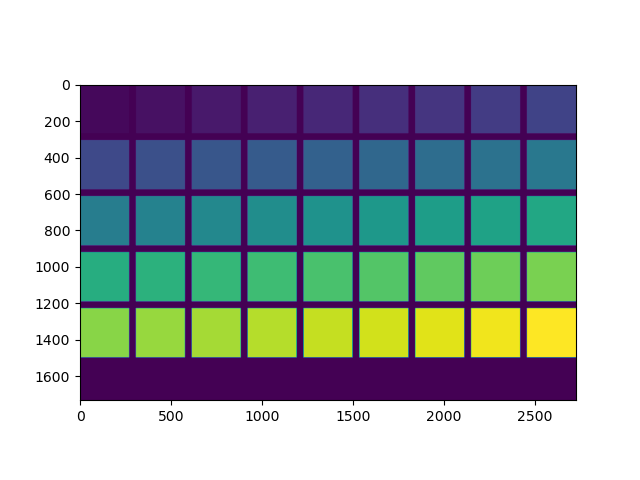

In [9]:
def pad_to_image(src, dst):
    """
    add 0 value padding to a source image in order to have the dimensions of dst,
    or its own dimension if the source is larger than the destination for any given axis 
    :param src: the source image to pad
    :param dst: the destination image to use as minimum final size
    :return: a possibly padded source image
    """
    final_shape = max(src.shape[0], dst.shape[0]), max(src.shape[1], dst.shape[1])
    padded = np.zeros(final_shape, dtype='uint8')
    padded[:src.shape[0], :src.shape[1]] = src
    return padded
    
padded_color_checker = pad_to_image(color_checker, corrected)
padded_fig_checker = plt.figure()
plt.imshow(padded_color_checker)

In [10]:
def overlay_color_checker(image, color_checker, patch_alpha = 1, non_patch_alpha = 0.5):
    """
    builds an image where the position of the color_checker pattern patches is encoded as the transparency of the image
    :param image: source image on which to overlay the color_checker
    :param color_checker: color checker to overlay. Needs to be at least as large as image
    :param patch_alpha: transparency value to use when at position of a color checker patch
    :param non_patch_alpha: transparency value to use when not at position of a color checker patch
    :return: a numpy array of 4 value pixels: (R, G, B, A) in range [0,1]
    """
    color_checker = (color_checker[:image.shape[0], :image.shape[1]] >= 1 ) * patch_alpha + (color_checker[:image.shape[0], :image.shape[1]] < 1 ) * non_patch_alpha
    return np.dstack((image, color_checker))


Output()

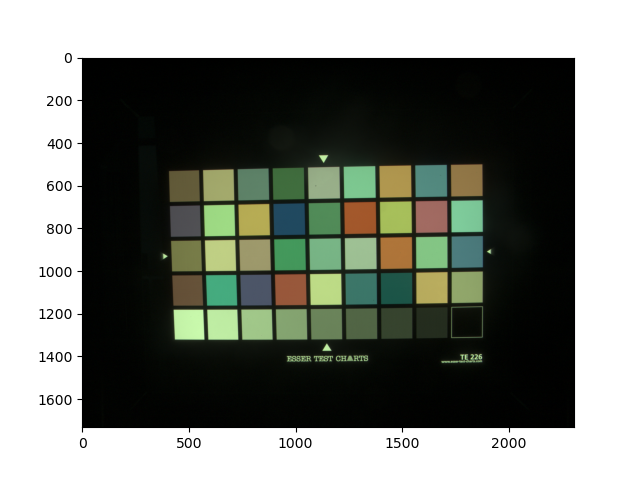

In [79]:
from matplotlib.backend_bases import MouseEvent
from color_transfer_helper import ColorCheckerLocation
import ipywidgets as widgets
import cv2

plt.close('all')

CC_in_raw = ColorCheckerLocation()
CC_in_pattern = ColorCheckerLocation.build_from_pattern(color_checker)

fig_overlay = plt.figure()
im_overlay = plt.imshow(corrected)
out = widgets.Output()

@out.capture()
def onclick(event: MouseEvent):
    global new_CC

    button_to_coord_map = {(1, None): 'top_left', (3, None): 'top_right', (1, 'shift'): 'bottom_left', (3, 'shift'): 'bottom_right'}
    setattr(CC_in_raw, button_to_coord_map[(event.button,event.key)], (event.xdata, event.ydata))
        
    if CC_in_raw.is_initialized():
        M = cv2.getPerspectiveTransform(CC_in_pattern.to_np_array(), CC_in_raw.to_np_array())
        new_CC = cv2.warpPerspective(padded_color_checker, M, (corrected.shape[1], corrected.shape[0]))
        im_overlay.set_data(overlay_color_checker(corrected, new_CC))
        fig_overlay.canvas.draw_idle()
        
display(out)
cid = fig_overlay.canvas.mpl_connect('button_press_event', onclick)

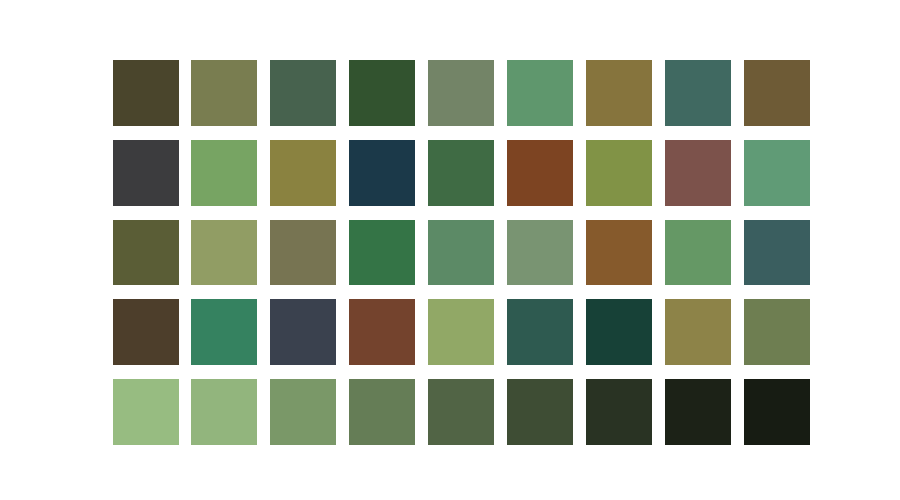

In [118]:
def plot_patches(patches: np.ndarray, num_patches_per_row: int, white_level: int):
    num_cols = int(num_patches_per_row)
    num_rows = int(patches.shape[0]/num_patches_per_row)
    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, i*num_cols+j+1)
            plt.imshow(np.expand_dims(invgamma(patches[i*num_cols+j], white_level),1))
            plt.axis('off')

def extract_patches(image: np.ndarray, patch_location: np.ndarray):
    number_patches = int(np.max(patch_location))
    extracted_colors = [np.mean(image[patch_location == i+1], axis=0) for i in range(number_patches)]
    return np.expand_dims(np.array(extracted_colors),1)

plot_patches(extract_patches(level_corrected, new_CC), 9, white_level)

# Failed tests

In [ ]:
import cv2

In [ ]:
# test 1: square detection
# Load image, grayscale, and Otsu's threshold
nparr = np.asarray(bytearray(thumb), dtype="uint8")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY )[1]

# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Find contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter for rectangles and squares
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
# Display the image
cv2.imshow('Detected Rectangles and Squares', image)
cv2.waitKey(0)

In [ ]:
# test 2: Hough line transform
# Load image, grayscale, Canny edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Use HoughLinesP to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Display the image
cv2.imshow('Hough Lines', image)
cv2.waitKey(0)